# Report on Decision Tree Learning Algorithm using Python

by Ruijie Rao on 2022/02/01

## 1. Data Preparation

### 1.0 Config

In this assignment, I will be importing pandas as my data processing library.

In [1]:
import pandas as pd
import numpy as np

In [2]:
data_path = "dt_data.txt"

### 1.1 Load Data with Pandas Library

In order to help pandas read txt file better, I removed "()" from the data file column row, and replaced ":" with commas.

In [3]:
raw_df = pd.read_csv(data_path).set_index("Id")

Here is a preview of the data:

In [4]:
raw_df.head()

,Occupied,Price,Music,Location,VIP,FavoriteBeer,Enjoy
Id,,,,,,,
1,High,Expensive,Loud,Talpiot,No,No,No
2,High,Expensive,Loud,City-Center,Yes,No,Yes
3,Moderate,Normal,Quiet,City-Center,No,Yes,Yes
4,Moderate,Expensive,Quiet,German-Colony,No,No,No
5,Moderate,Expensive,Quiet,German-Colony,Yes,Yes,Yes


In [5]:
raw_df.columns

Index(['Occupied', 'Price', 'Music', 'Location', 'VIP', 'FavoriteBeer',
       'Enjoy'],
      dtype='object')

### 1.2 Data Structure Description

In [6]:
for col in raw_df.columns:
    column_data = raw_df[col]
    categories = column_data.unique()
    print(f"Categories for Column {col} includes: {','.join(categories)}")

Categories for Column Occupied includes: High,Moderate,Low
Categories for Column Price includes: Expensive,Normal,Cheap
Categories for Column Music includes: Loud,Quiet
Categories for Column Location includes: Talpiot,City-Center,German-Colony,Ein-Karem,Mahane-Yehuda
Categories for Column VIP includes: No,Yes
Categories for Column FavoriteBeer includes: No,Yes
Categories for Column Enjoy includes: No,Yes


### 1.3 Data Formating

To better evaluate the data, I am going to change the data type of columns: *Enjoy* to dtype **Boolean**

In [7]:
df = raw_df
for col_name in ['Enjoy']:
    df[col_name] = raw_df[col_name].map({"Yes":True,"No":False})

In [8]:
df.dtypes

Occupied        object
Price           object
Music           object
Location        object
VIP             object
FavoriteBeer    object
Enjoy             bool
dtype: object

### 1.4 Categorizing data

There are benefits of changing dtype to category. One is that it helps with understanding, because all the columns of our data is categorical. Another one is that, after filtering, if a specific category data counts as 0, the category will still exist. This will help us in calculating P in the Entropy Formula.

In [9]:
from pandas.api.types import CategoricalDtype

In [10]:
df = raw_df
for col in df.drop("Enjoy",axis=1).columns:
    column_data = df[col]
    categories = column_data.unique()
    cat_type = CategoricalDtype(categories)
    df[col] = column_data.astype(cat_type)

In [11]:
df.dtypes

Occupied        category
Price           category
Music           category
Location        category
VIP             category
FavoriteBeer    category
Enjoy               bool
dtype: object

In [12]:
df["count"] = [1 for i in range(len(df))]

In [13]:
eva_col = set(df.drop(["Enjoy","count"],axis=1).columns)

## 2. Decision Tree Generation

### 2.0.1 Test and Construct Functions to calculate Entropy of a tree branch using Pandas Groupby

Defining aggregate functions for groupby object:

In [14]:
def p(x):
    result = x/x.sum()
    return result
def entropy(x):
    result = -1*np.sum(x.logp*x.p)
    return result

Idea: Using aggregate function on level 0 of the groupby object to calculate the necessary ingredients for Entropy Function:

$$
E = -\sum_{n=0}^{N}p_{n}log(p_{n})
$$

In [15]:
df_branch = df.groupby(["VIP"]).count()[["count"]]
df_leaf = df.groupby(["VIP","Enjoy"]).count()[["count"]]
df_leaf["p"] = df_leaf.groupby(level=[0]).apply(p)[["count"]]
df_leaf["logp"] = df_leaf["p"].apply(np.log2)

As you see in the below display, we need **count** to calculate **p**, and need **p**  for **logp**:

In [16]:
df_leaf

count         p      logp
VIP Enjoy                           
No  False      8  0.500000 -1.000000
    True       8  0.500000 -1.000000
Yes False      1  0.166667 -2.584963
    True       5  0.833333 -0.263034

Then, we use these variables and the aggregate function **entropy(x)** to calculate entropy for each categories of a leaf node:

In [17]:
df_branch["entropy"] = df_leaf.groupby(level=[0]).apply(entropy)
df_branch["count*entropy"] = df_branch["count"]*df_branch["entropy"]
display(df_branch)

,count,entropy,count*entropy
VIP,,,
No,16,1.000000,16.000000
Yes,6,0.650022,3.900135


Next, calculate the average Entropy for this branch:
$$ E_{\mu} = \frac{1}{N} \sum_{n=0}^{N} p_{n}E_{n} $$

In [18]:
branch_mean_entropy = sum(df_branch["count*entropy"])/sum(df_branch["count"])
print(f"Mean Entropy for VIP: {branch_mean_entropy}")

Mean Entropy for VIP: 0.9045515695404602


Bundle as a function:

In [19]:
def cal_node_entropy(col,df):
    df_branch = df.groupby([col]).count()[["count"]]
    df_leaf = df.groupby([col,"Enjoy"]).count()[["count"]]
    df_leaf["p"] = df_leaf.groupby(level=[0]).apply(p)[["count"]]
    df_leaf["logp"] = df_leaf["p"].apply(np.log2)
    df_branch["entropy"] = df_leaf.groupby(level=[0]).apply(entropy)
    df_branch["count*entropy"] = df_branch["count"]*df_branch["entropy"]
    branch_mean_entropy = sum(df_branch["count*entropy"])/sum(df_branch["count"])
    return branch_mean_entropy

Test for other column roots:

In [20]:
for col in eva_col:
    branch_mean_entropy = cal_node_entropy(col,df)
    print(f"Mean Entropy for {col}: {branch_mean_entropy} \n")

Mean Entropy for Price: 0.9618754299422804 

Mean Entropy for Music: 0.9460413178321331 

Mean Entropy for Location: 0.8423667716199763 

Mean Entropy for Occupied: 0.8377027064941335 

Mean Entropy for FavoriteBeer: 0.8626230013039753 

Mean Entropy for VIP: 0.9045515695404602 



### 2.0.2 Termination Criteria

**Termination Rule**: According to lecture, there are 3 criteria:
1. Branch becomes pure.
2. Branch is simple, then tolerates slight impurity
3. Loop ends

I will define "Slight Impurity" by 0.2 and define a tree to be non-complex if its level is smaller or equal to 3 for my first tests, may need optimization afterwards.

In [21]:
e_threshold = 0.2
lvl_threshold = 3

In [22]:
def termination_check(df,history):
    if len(df["Enjoy"].unique()) == 1: ## Criteria 1: Pure
        return True
    elif len(history) == 6:
        return True #"Complexity Maximum Reached"
    elif df.empty:
        return True
    else:
        return False

### 2.0.2 Construct Outer Loop

**Loop Description**: On the outer, we will be looping through the columns: Occupied, Price, Music, Location, VIP, and FavoriteBeer. Every loop the entropy values will be recorded and the Node with min Entropy(max Information gain) will be chosen as the branch of this level, continuing to the next loop.

I will use a dict as the tree to record the nodes:

In [ ]:
{
    "Parent_Node": None,
    "Entropy": 1,
    "Node_df": df,
    "Child_Node": [{
                        "Node_name": None,
                        "Node_info": None
                    }],
    "History":[]
}

The construction will be a recursive loop.

Firstly, the loop checks termination. If terminated, it will output the termination node of column "Enjoy".

In [ ]:
if response == True: ## Need Modify
    print("Terminated")
    return {"Termination": current_node_df["Enjoy"].unique()}
current_node = {
    "Parent_Node": None,
    "Entropy": 1
}

Then, it loops through all the columns that have not been splitted on in history and find the column with minimum Entropy.

In [ ]:
for column_name in eva_col: 
    if column_name in history: continue
    node_mean_entropy = cal_node_entropy(column_name,current_node_df)
    if node_mean_entropy < current_node["Entropy"]:
        current_node = {
            "Parent_Node": column_name,
            "Entropy": node_mean_entropy,
        }

Next, it records the information of this column including Entropy, column name, history, dataframe and all the child nodes it holds.

In [ ]:
current_column_name = current_node["Parent_Node"]
current_node["Node_df"] = current_node_df
current_node["History"] = history+[current_column_name]
current_node_df_gb = current_node_df.groupby(current_column_name)

Finally, recursion happens in the child node section by recording the node it split on and go through all the processes again on that node.

In [ ]:
current_node["Child_Node"] = [
    {
        "Node_name": child_node_name,
        "Node_info": gen_decision_tree(child_node_df, current_node["History"])
    }
    for child_node_name,child_node_df in current_node_df_gb
]

The function is ultimatedly gathered as:

In [23]:
def gen_decision_tree(current_node_df, history):
    display(current_node_df)
    response = termination_check(current_node_df,history)
    if response == True: ## Need Modify
        return {"Termination": [str(i) for i in current_node_df["Enjoy"].unique()]}
    current_node = {
        "Parent_Node": None,
        "Entropy": 1
    }
    for column_name in eva_col: 
        if column_name in history: continue
        node_mean_entropy = cal_node_entropy(column_name,current_node_df)
        if node_mean_entropy < current_node["Entropy"]:
            current_node = {
                "Parent_Node": column_name,
                "Entropy": node_mean_entropy,
            }
    current_column_name = current_node["Parent_Node"]
    if current_column_name==None: return {}
    #current_node["Node_df"] = current_node_df
    current_node["History"] = history+[current_column_name]
    current_node_df_gb = current_node_df.groupby(current_column_name)
    current_node["Child_Node"] = [
                    {
                        "Node_name": child_node_name,
                        "Node_info": gen_decision_tree(child_node_df, current_node["History"])
                    }
                    for child_node_name,child_node_df in current_node_df_gb
                ]
    return current_node

### 2.0.3 Construct initiation for recursion

In order to start the recursion loop, a initiation is needed to kick off the rest of the loop. It is simply a different version of the function.

## 2.1 Test tree

Here goes the test: (For debugging purpose, every df is displayed)

In [27]:
# Initiation
current_node = {
    "Parent_Node": None,
    "Entropy": 1,
    #"Node_df": df,
    "History":[],
    "Child_Node": []
}
for column_name in eva_col: 
        node_mean_entropy = cal_node_entropy(column_name,df)
        if node_mean_entropy < current_node["Entropy"]:
            current_node["Parent_Node"] = column_name
            current_node["Entropy"] = node_mean_entropy
current_column_name = current_node["Parent_Node"]
current_node["History"].append(current_node["Parent_Node"])
current_history = current_node["History"]
current_node_df_gb = df.groupby(current_column_name)
current_node["Child_Node"] = [
                        {
                            "Node_name": child_node_name,
                            "Node_info": gen_decision_tree(child_node_df, current_history)
                        }
                        for child_node_name,child_node_df in current_node_df_gb
                    ]
tree = current_node

,Occupied,Price,Music,Location,VIP,FavoriteBeer,Enjoy,count
Id,,,,,,,,
1,High,Expensive,Loud,Talpiot,No,No,False,1
2,High,Expensive,Loud,City-Center,Yes,No,True,1
9,High,Expensive,Loud,City-Center,Yes,Yes,True,1
14,High,Normal,Loud,Mahane-Yehuda,Yes,Yes,True,1
16,High,Normal,Quiet,German-Colony,No,No,False,1
17,High,Cheap,Loud,City-Center,No,Yes,True,1


,Occupied,Price,Music,Location,VIP,FavoriteBeer,Enjoy,count
Id,,,,,,,,
1,High,Expensive,Loud,Talpiot,No,No,False,1


,Occupied,Price,Music,Location,VIP,FavoriteBeer,Enjoy,count
Id,,,,,,,,
2,High,Expensive,Loud,City-Center,Yes,No,True,1
9,High,Expensive,Loud,City-Center,Yes,Yes,True,1
17,High,Cheap,Loud,City-Center,No,Yes,True,1


,Occupied,Price,Music,Location,VIP,FavoriteBeer,Enjoy,count
Id,,,,,,,,
16,High,Normal,Quiet,German-Colony,No,No,False,1


,Occupied,Price,Music,Location,VIP,FavoriteBeer,Enjoy,count
Id,,,,,,,,


,Occupied,Price,Music,Location,VIP,FavoriteBeer,Enjoy,count
Id,,,,,,,,
14,High,Normal,Loud,Mahane-Yehuda,Yes,Yes,True,1


,Occupied,Price,Music,Location,VIP,FavoriteBeer,Enjoy,count
Id,,,,,,,,
3,Moderate,Normal,Quiet,City-Center,No,Yes,True,1
4,Moderate,Expensive,Quiet,German-Colony,No,No,False,1
5,Moderate,Expensive,Quiet,German-Colony,Yes,Yes,True,1
6,Moderate,Normal,Quiet,Ein-Karem,No,No,True,1
8,Moderate,Cheap,Loud,Mahane-Yehuda,No,No,True,1
11,Moderate,Cheap,Loud,Talpiot,No,Yes,False,1
13,Moderate,Expensive,Quiet,Mahane-Yehuda,No,Yes,True,1
15,Moderate,Normal,Loud,Ein-Karem,No,Yes,True,1
20,Moderate,Normal,Quiet,Talpiot,No,No,True,1


,Occupied,Price,Music,Location,VIP,FavoriteBeer,Enjoy,count
Id,,,,,,,,
11,Moderate,Cheap,Loud,Talpiot,No,Yes,False,1
20,Moderate,Normal,Quiet,Talpiot,No,No,True,1


,Occupied,Price,Music,Location,VIP,FavoriteBeer,Enjoy,count
Id,,,,,,,,


,Occupied,Price,Music,Location,VIP,FavoriteBeer,Enjoy,count
Id,,,,,,,,
20,Moderate,Normal,Quiet,Talpiot,No,No,True,1


,Occupied,Price,Music,Location,VIP,FavoriteBeer,Enjoy,count
Id,,,,,,,,
11,Moderate,Cheap,Loud,Talpiot,No,Yes,False,1


,Occupied,Price,Music,Location,VIP,FavoriteBeer,Enjoy,count
Id,,,,,,,,
3,Moderate,Normal,Quiet,City-Center,No,Yes,True,1


,Occupied,Price,Music,Location,VIP,FavoriteBeer,Enjoy,count
Id,,,,,,,,
4,Moderate,Expensive,Quiet,German-Colony,No,No,False,1
5,Moderate,Expensive,Quiet,German-Colony,Yes,Yes,True,1


,Occupied,Price,Music,Location,VIP,FavoriteBeer,Enjoy,count
Id,,,,,,,,
4,Moderate,Expensive,Quiet,German-Colony,No,No,False,1


,Occupied,Price,Music,Location,VIP,FavoriteBeer,Enjoy,count
Id,,,,,,,,
5,Moderate,Expensive,Quiet,German-Colony,Yes,Yes,True,1


,Occupied,Price,Music,Location,VIP,FavoriteBeer,Enjoy,count
Id,,,,,,,,
6,Moderate,Normal,Quiet,Ein-Karem,No,No,True,1
15,Moderate,Normal,Loud,Ein-Karem,No,Yes,True,1


,Occupied,Price,Music,Location,VIP,FavoriteBeer,Enjoy,count
Id,,,,,,,,
8,Moderate,Cheap,Loud,Mahane-Yehuda,No,No,True,1
13,Moderate,Expensive,Quiet,Mahane-Yehuda,No,Yes,True,1


,Occupied,Price,Music,Location,VIP,FavoriteBeer,Enjoy,count
Id,,,,,,,,
7,Low,Normal,Quiet,Ein-Karem,No,No,False,1
10,Low,Cheap,Quiet,City-Center,No,No,False,1
12,Low,Cheap,Quiet,Talpiot,Yes,Yes,False,1
18,Low,Normal,Quiet,City-Center,No,No,False,1
19,Low,Expensive,Loud,Mahane-Yehuda,No,No,False,1
21,Low,Normal,Quiet,City-Center,No,No,True,1
22,Low,Cheap,Loud,Ein-Karem,Yes,Yes,True,1


,Occupied,Price,Music,Location,VIP,FavoriteBeer,Enjoy,count
Id,,,,,,,,
12,Low,Cheap,Quiet,Talpiot,Yes,Yes,False,1


,Occupied,Price,Music,Location,VIP,FavoriteBeer,Enjoy,count
Id,,,,,,,,
10,Low,Cheap,Quiet,City-Center,No,No,False,1
18,Low,Normal,Quiet,City-Center,No,No,False,1
21,Low,Normal,Quiet,City-Center,No,No,True,1


,Occupied,Price,Music,Location,VIP,FavoriteBeer,Enjoy,count
Id,,,,,,,,


,Occupied,Price,Music,Location,VIP,FavoriteBeer,Enjoy,count
Id,,,,,,,,
18,Low,Normal,Quiet,City-Center,No,No,False,1
21,Low,Normal,Quiet,City-Center,No,No,True,1


,Occupied,Price,Music,Location,VIP,FavoriteBeer,Enjoy,count
Id,,,,,,,,
10,Low,Cheap,Quiet,City-Center,No,No,False,1


,Occupied,Price,Music,Location,VIP,FavoriteBeer,Enjoy,count
Id,,,,,,,,


,Occupied,Price,Music,Location,VIP,FavoriteBeer,Enjoy,count
Id,,,,,,,,
7,Low,Normal,Quiet,Ein-Karem,No,No,False,1
22,Low,Cheap,Loud,Ein-Karem,Yes,Yes,True,1


,Occupied,Price,Music,Location,VIP,FavoriteBeer,Enjoy,count
Id,,,,,,,,


,Occupied,Price,Music,Location,VIP,FavoriteBeer,Enjoy,count
Id,,,,,,,,
7,Low,Normal,Quiet,Ein-Karem,No,No,False,1


,Occupied,Price,Music,Location,VIP,FavoriteBeer,Enjoy,count
Id,,,,,,,,
22,Low,Cheap,Loud,Ein-Karem,Yes,Yes,True,1


,Occupied,Price,Music,Location,VIP,FavoriteBeer,Enjoy,count
Id,,,,,,,,
19,Low,Expensive,Loud,Mahane-Yehuda,No,No,False,1


## 2.2 Display the Tree

### 2.2.1 Formatting the Tree

Since my tree is in Dict form, I assume converting it to json would be a better way of displaying it.

In [30]:
import json
def display_tree(tree):
    print(json.dumps(tree, indent=4))

In [31]:
display_tree(tree)

{
    "Parent_Node": "Occupied",
    "Entropy": 0.8377027064941335,
    "History": [
        "Occupied"
    ],
    "Child_Node": [
        {
            "Node_name": "High",
            "Node_info": {
                "Parent_Node": "Location",
                "Entropy": 0.0,
                "History": [
                    "Occupied",
                    "Location"
                ],
                "Child_Node": [
                    {
                        "Node_name": "Talpiot",
                        "Node_info": {
                            "Termination": [
                                "False"
                            ]
                        }
                    },
                    {
                        "Node_name": "City-Center",
                        "Node_info": {
                            "Termination": [
                                "True"
                            ]
                        }
                    },
                    {
          

### 2.2.2 Explaining the Tree

As you see the tree above, let me help you explain its structure:

Different nodes represent different meanings:
* **Parent_Node** is the chosen column name with the minimum mean entropy among all other available choices.
* **Entropy** is the chosen columns's mean Entropy, which should be the minimum in list.
* **History** records all the upper level **Parent_Node**.
* **Child_Node** is a list including all the possible splittings of the **Parent_Node**:
    * **Node_name** is the name of the split node inside **Child_Node** eg. "Yes" and "No" under column "VIP".
    * **Node_info** is the dict that includes all the above information for the next level.
* **Termination** only appears when termination check return **True**. It should output a Bool value for "Enjoy" column, unless the splitting node has no data to decide.

## 3. Prediction

Test case: (occupied = Moderate; price = Cheap; music = Loud; location = City-Center; VIP = No; favorite beer = No)

According to the tree I outputed:
1. **Occupied** = Moderate
2. **Location** = City-Center
3. **Terminates**.

Result is **Enjoy** = **True**.

### 3.1 Prediction Evidence

I will display the dataframe to help proof my prediction:

**Occupied** = Moderate

**Location** = City-Center:

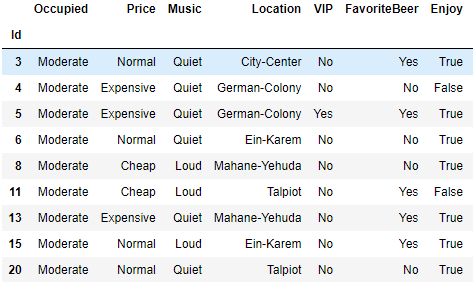

Which **Terminates** the Prediction as **True**.

## 4. Challenges, Optimization and Possible Improvements

### 4.1 Challenges

**Challenge 1**: My first design of the tree was not a recursion model. It was a dict with keys equal to levels like following:

In [ ]:
tree = {
    0: [{
        "column_name":None,
        "entropy": 1,
        "df": None
    }],
    1: [{
        "column_name":None,
        "entropy": 1,
        "df": None
    },{
        "column_name":None,
        "entropy": 1,
        "df": None
    }],
    2: [{
        "column_name":None,
        "entropy": 1,
        "df": None
    }]
}

However, the intuition is wrong. In this structure, branches in the same level are related as list, but relationship between different levels is weak. As a decision tree, horizontal relationship is not as crucial as vertical relationship. As a result, a recursion tree would be the best to demonstrate relationships between parent nodes and child chodes.

**Challenge 2**: Designing the recursion tree is a huge difficulty for me. I have never designed any recursion model, and the inspiration came from internet when I searched for "Types of Loops". During the construction process, I started by writing the ending part of the loop where data is transfered from this iteration to the next. Then, I came back to the top to finish the loop by imagining how shoud the data transfered be processed on the next iteration. This part of the algorithm took me many hours to design and construct.

**Challenge 3**: Some Termination Nodes lacks any result as shown in the tree:

In [ ]:
{
    "Node_name": "Expensive",
    "Node_info": {
        "Termination": []
    }
},

This is because the data under this branch is missing/empty. 

For example, with a history of "*Occupied* = Low, *Location* = Erin", there is not data point with a *Price* = Expensive. Unfortunately, I dont really have any idea to solve this problem yet.

### 4.2 Optimization

**Optimization 1**: My first attempt on the task was not using pandas except the data loading process. I was trying to use a lot of loops and functions to accomplish the calculation part, until I recalled using Pandas during my internship opportunity. My original attempt was using pandas.pivot_table(), but found out that pandas.groupby.apply() was a much easier approach. Using pandas really saved a lot of looping and extra coding for me.

**Optimization 2**: My first attempt on the task was not using pandas except the data loading process. I was trying to use a lot of loops and functions to accomplish the calculation part, until I recalled using Pandas during my internship opportunity. My original attempt was using pandas.pivot_table(), but found out that pandas.groupby.apply() was a much easier approach. Using pandas really saved a lot of looping and extra coding for me.

After searching for solutions, I found that when p=0, the entropy is skipped:
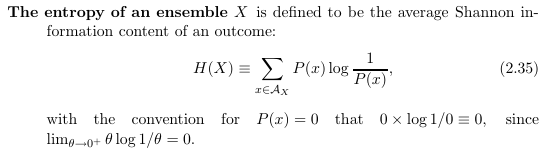

As a result, I will be altering my entropy calculation process to skip those p=0.

### 4.3 Possible Impovements

After trying out the SkLearn Decision Tree Model, I found out that the result is a bit different from mine. One reason is that the training dataset is required to be converted into numeric values instead of strings. However, changing data to numeric value implies random ordering for values. For example,"Low" "Moderate" and "High" are numbered as 0,2,1 according to when they first appear on the dataset. On the other hand, it gives me an inspiration on combining different categories into new ones. For example, combining "Low" and "High" into new categories called "Low and High" and see if its entropy is smaller. This potentially solves the issue of lacking data for some of the splitting nodes and also may increase the accuracy.